In [1]:
from scmodels import SCM
import random, math

In [2]:
def get_distributions():
    dists = [
        f"LogLogistic(alpha={random.randint(5, 20)}, beta={round(random.uniform(1,3.5),1)})",
        f"Normal(mean={random.randint(0,10)}, std={round(random.uniform(1,20),2)})",
        f"LogNormal(mean={random.randint(0,10)}, std={round(random.uniform(1,20),2)})",
        f"Benini(alpha={round(random.uniform(.1, 1.0), 1)}, beta={round(random.uniform(.1, 1.0), 1)}, sigma={round(random.uniform(.1, 1.0), 1)})",
        f"Beta(alpha={round(random.uniform(.1, 1.0), 1)}, beta={round(random.uniform(.1, 1.0), 1)})",
        f"Exponential(rate={round(random.uniform(.5, 10.0), 1)})",
        f"FDistribution(d1={random.randint(2, 4)}, d2={random.randint(5, 8)})",
        f"Gamma(k={round(random.uniform(0.1, 4.0), 1)}, theta={round(random.uniform(2.0, 8.0), 1)})",
        f"GammaInverse(a={round(random.uniform(0.1, 4.0), 1)}, b={round(random.uniform(2.0, 8.0), 1)})",
        f"Bernoulli({round(random.random(), 1)})",
        f"Binomial(n={random.randint(2, 10)}, p={round(random.uniform(.1, 1.0), 1)}, succ={random.randint(3, 20)}, fail={random.randint(3, 20)})",
        f"BetaBinomial(n={random.randint(10, 100)}, alpha={round(random.uniform(.1, 1.0), 1)}, beta={round(random.uniform(2, 5),1)})",
        f"Die(sides={random.randint(4, 10)})",
        f"FiniteRV({{1: 0.33, 2: 0.34, 3: 0.33}})",
        f"Geometric(p={round(random.uniform(0.05, 1.00), 2)})",
        f"Poisson(lamda={round(random.uniform(0.05, 1.00), 1)})",
        f"FiniteRV({{{random.randint(5, 10)}: 0.5, {random.randint(0, 3)}: 0.16, {random.randint(15, 25)}: 0.17, {random.randint(30, 50)}: 0.17}})"
    ]
    
    return dists

In [3]:
def add_noise(dist):
    noise_ops = [False, True]
    op = random.choices(noise_ops, weights=(5, 1), k=1)[0]
    if op:
        dist = f"( {dist} ) * N"
    
    return dist

In [4]:
def add_complex_operation(dist):
    complex_ops = [False, "sqrt", "**2"]
    op = random.choices(complex_ops, weights=(10, 1, 1), k=1)[0]
    if op:
        if "*" in op:
            dist = f"( {dist} ){op}"
        else:
            dist = f"{op} ( {dist} )"
    
    return dist

In [5]:
def create_simple_operation(dist, parent):
    simple_ops = ["+", "*", "()"]
    op_1 = random.choices(simple_ops, weights=(4, 4, 1), k= 1)[0]
    if op_1 == "()":
        op_2 = random.choices(simple_ops, weights=(1, 1, 0), k= 1)[0]
        dist = f"{op_1[0]} {dist} {op_2} {parent} {op_1[1]}"
    else:
        dist = f"{dist} {op_1} {parent}"
    
    return dist

In [6]:
def get_distribution(parents):
    if not parents:
        dist = "N"
    else:
        dist = f"{parents[0]}"
        count = 0
        for p in parents[1:]:
            dist = create_simple_operation(dist, p)
            count += 1

            if count > 2:
                dist = add_complex_operation(dist)
                count = 0

            dist = add_noise(dist)

        dist = f"{dist} * N"
        
    return dist

In [7]:
def get_parent_levels(levels_and_distributions):
    levels = list(range(len(levels_and_distributions)))
    level_probs = [round(math.exp(1.5 * l), 1) for l in levels]
    parent_levels = []
    for l in levels:
        possible_level = random.choices(levels, level_probs, k=1)[0]
        if possible_level not in parent_levels:
            parent_levels.append(possible_level)
    
    return parent_levels

In [8]:
def get_parents(levels_and_distributions):
    parents = []
    parent_levels = get_parent_levels(levels_and_distributions)
    for level in parent_levels:
        possible_parents = levels_and_distributions[level][1]
        num_parents = random.randint(1, len(possible_parents))
        parents.extend(random.sample(possible_parents, num_parents))
    
    return parents

In [9]:
def populate_level_distributions(level, level_data, levels_and_distributions):
    level_dists = []
    dist_names = []
    for n in range(level_data['num']):
        name = level_data['name']+str(n+1)
        dist = get_distribution(get_parents(levels_and_distributions))
            
        dist = f"{name} = {dist}, N ~ {random.sample(get_distributions(), 1)[0]}"
        level_dists.append(dist)
        dist_names.append(name)
    
    levels_and_distributions[level] = (level_dists, dist_names)

In [10]:
def create_scm(level_name_numnodes):
    levels_and_distributions = {}
    for level, level_data in level_name_numnodes.items():
        populate_level_distributions(level, level_data, levels_and_distributions)

    scm_dists = []
    for n in range(len(levels_and_distributions)):
        scm_dists.extend(levels_and_distributions[n][0])
    
    scm = SCM(
        scm_dists
    )
    
    return scm

In [11]:
def create_names_and_num_nodes_dict(nodes_per_level, level_names):
    level_name_numnodes = {}
    for n, name in enumerate(level_names):
        level_name_numnodes[n] = {'name': name, 'num': nodes_per_level[n]}
        
    return level_name_numnodes

In [12]:
def get_level_names(numnodes_per_level):
    level_names = []
    for n in range(len(numnodes_per_level)):
        level_names.append(chr(65 + n))
    
    return level_names

In [13]:
def create_scm_from_nodes_list(nodes_list):
    level_names = get_level_names(nodes_list)
    level_name_numnodes = create_names_and_num_nodes_dict(nodes_list, level_names)
    
    scm = create_scm(level_name_numnodes)
    return scm

In [14]:
def get_numnodes_per_level(input_nodes):
    nodes = input_nodes
    levels = int(math.pow(nodes, 1/3))
    numnodes_per_level = []
    for n in range(levels):
        ub = round(math.log(nodes)) - 0.6
        lb = ub - 0.7
        level_nodes = int(math.exp(round(random.uniform(lb,ub), 1)))
        if level_nodes == 0 : break

        numnodes_per_level.append(level_nodes)
        nodes -= level_nodes
        
    return numnodes_per_level

In [15]:
def create_scm_from_num_nodes(input_nodes):
    nodes_list = get_numnodes_per_level(input_nodes)
    scm = create_scm_from_nodes_list(nodes_list)
    return scm

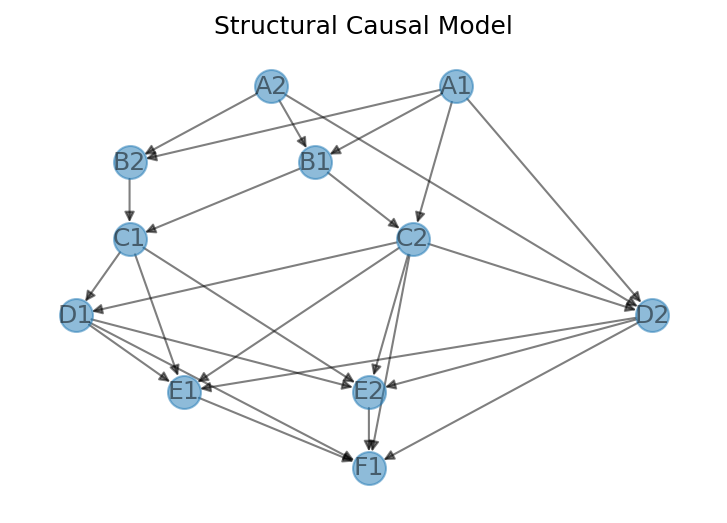

In [16]:
input_nodes = [2,2,2,2,2,1]
if __name__ == "__main__":  
    if type(input_nodes) != list:
        scm = create_scm_from_num_nodes(input_nodes)
    else:
        scm = create_scm_from_nodes_list(input_nodes)
    scm.plot(node_size=250);

In [17]:
scm.sample(100)

C:\Users\uvgupta\software\miniconda3\envs\cdt\lib\site-packages\scmodels\scm.py:286: SymPyDeprecationWarning: 

The numsamples parameter to sympy.stats.sample() is deprecated.
Either use a list comprehension, like

[sample(...) for i in range(100)]

or add a dimension to size, like

sample(..., size=(100,))

See https://docs.sympy.org/latest/explanation/active-deprecations.html#deprecated-sympy-stats-numsamples
for details.

This has been deprecated since SymPy version 1.9. It
will be removed in a future version of SymPy.

  list(sample(noise_gen, numsamples=n, seed=seed)), dtype=float


,A1,A2,B1,B2,C2,C1,D2,D1,E1,E2,F1
0,6.894582,2.0,27.578329,7.070635,310.256206,34.648965,5.134009e+04,2.678837e+04,3.265949e+16,1.569467e+05,1.077763e+18
1,233.435629,1.0,2567.791924,234.948776,2801.227553,61861.954941,6.539064e+06,1.150081e+07,2.757602e+25,9.052266e+07,8.272805e+26
2,1294.294635,3.0,34945.955147,1294.327561,144960.999130,36240.282708,1.876222e+09,4.010294e+07,9.107219e+29,7.666026e+09,3.278599e+31
3,3.629181,2.0,14.516722,3.754002,18.145903,18.270724,2.000000e+00,2.924530e+02,4.283672e+08,2.316088e+03,1.670642e+10
4,1614.489146,2.0,54892.630968,1615.470923,226028.480455,550541.780600,2.000000e+00,2.259265e+08,1.242071e+23,1.586922e+09,4.471455e+24
...,...,...,...,...,...,...,...,...,...,...,...
95,43.839422,1.0,175.357687,44.676925,876.788433,44.676925,9.225105e+05,4.381858e+04,3.350606e+18,4.836253e+06,1.206218e+20
96,12.412735,1.0,186.191031,12.558648,1787.433897,198.749679,8.209179e+05,9.669597e+05,5.710440e+20,1.073918e+07,1.884445e+22
97,5.191340,2.0,62.296084,5.324379,67.487425,2310.279494,8.410405e+03,1.649766e+04,4.778840e+16,1.637150e+05,1.433652e+18
98,1670.691687,2.0,23389.683617,1671.887313,225543.377733,25061.570930,3.768134e+09,8.594451e+06,4.043697e+29,2.643886e+10,1.577042e+31


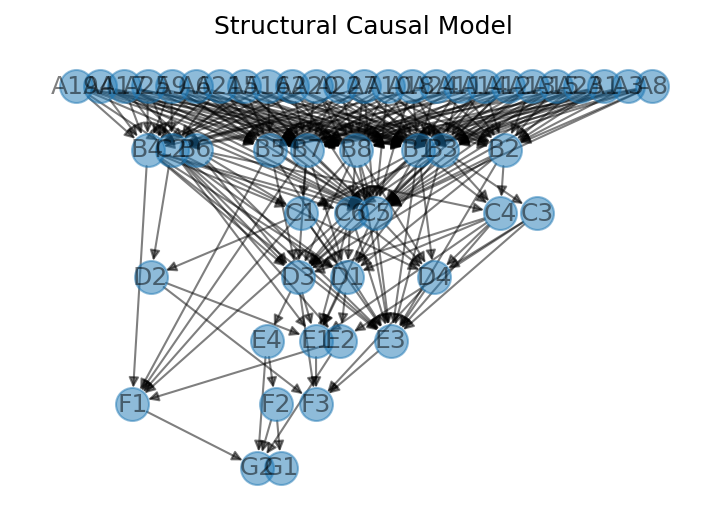

In [18]:
input_nodes = [25, 8, 6, 4, 4, 3, 2]
if __name__ == "__main__":  
    if type(input_nodes) != list:
        scm = create_scm_from_num_nodes(input_nodes)
    else:
        scm = create_scm_from_nodes_list(input_nodes)
    scm.plot(node_size=250);

In [19]:
scm.sample(100)

C:\Users\uvgupta\software\miniconda3\envs\cdt\lib\site-packages\scmodels\scm.py:286: SymPyDeprecationWarning: 

The numsamples parameter to sympy.stats.sample() is deprecated.
Either use a list comprehension, like

[sample(...) for i in range(100)]

or add a dimension to size, like

sample(..., size=(100,))

See https://docs.sympy.org/latest/explanation/active-deprecations.html#deprecated-sympy-stats-numsamples
for details.

This has been deprecated since SymPy version 1.9. It
will be removed in a future version of SymPy.

  list(sample(noise_gen, numsamples=n, seed=seed)), dtype=float
<lambdifygenerated-51>:2: RuntimeWarning: invalid value encountered in sqrt
  return A10*N + A11 + A13*A5 + A17 + sqrt(A6 + (A12 + A14*A7 + A16 + A18 + A22*A23*A9 + A3*(A1*A15*A2*A25*A8 + A20)*N)*N)


,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,...,D4,E2,E1,E4,E3,F1,F2,F3,G1,G2
0,0.732630,1.0,4.0,-16.381030,12.686942,9.0,1.0,15.275948,1.811440,1.841066,...,3.545309e+43,2.040561e+53,7.234419e+96,2.617951e+44,-0.000000e+00,-0.000000e+00,2.094361e+45,3.802364e+44,6.774883e+47,6.134812e+198
1,0.321567,1.0,11.0,1.717992,1.025341,9.0,0.0,4.702616,2.031058,0.241769,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.501770,1.0,1.0,-2.465426,2.284575,9.0,1.0,12.794635,0.470712,0.053165,...,-3.936867e+20,5.186851e+32,-4.094233e+53,-3.156163e+20,0.000000e+00,-0.000000e+00,-3.156163e+20,-1.414202e+21,-2.705103e+21,8.124810e+99
3,0.278573,1.0,1.0,24.733713,2.890738,50.0,0.0,18.706019,1.627386,19.787965,...,1.086108e+12,3.877951e+15,3.277024e+26,1.156992e+10,0.000000e+00,2.324480e+19,4.627968e+10,2.251604e+12,2.815263e+11,8.576625e+130
4,5.899853,1.0,1.0,14.113566,7.162754,9.0,1.0,11.147166,2.945193,6.444043,...,2.598697e+28,3.561136e+45,4.738241e+72,2.355754e+27,0.000000e+00,0.000000e+00,4.711507e+27,7.169998e+29,6.299342e+22,9.787650e+147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2.392845,1.0,8.0,-21.026544,5.828173,24.0,0.0,9.345466,0.406701,2.051656,...,2.277349e+15,1.235537e+21,4.968411e+35,1.026780e+15,8.411034e+28,0.000000e+00,3.080339e+15,1.530544e+86,2.862055e+16,1.364078e+79
96,1.321054,1.0,3.0,-12.287751,1.094422,24.0,0.0,7.707152,0.556107,1.061310,...,8.043455e+12,9.645437e+13,7.743794e+26,4.217893e+13,0.000000e+00,0.000000e+00,1.687157e+14,-2.816413e+13,6.948424e+07,1.092242e+79
97,0.490291,1.0,2.0,16.403843,1.400967,9.0,1.0,13.003998,2.812901,0.352678,...,3.695371e+28,1.295380e+49,4.453250e+76,1.267346e+29,0.000000e+00,9.391866e+69,1.267346e+29,-7.298946e+29,3.523811e+36,8.529124e+158
98,3.007905,1.0,1.0,26.018350,7.935211,9.0,0.0,24.629956,1.088930,0.465322,...,6.498572e+08,2.784516e+12,1.171562e+22,3.775349e+08,0.000000e+00,3.030701e+16,1.887674e+09,-4.255640e+09,3.456950e+18,4.187567e+83


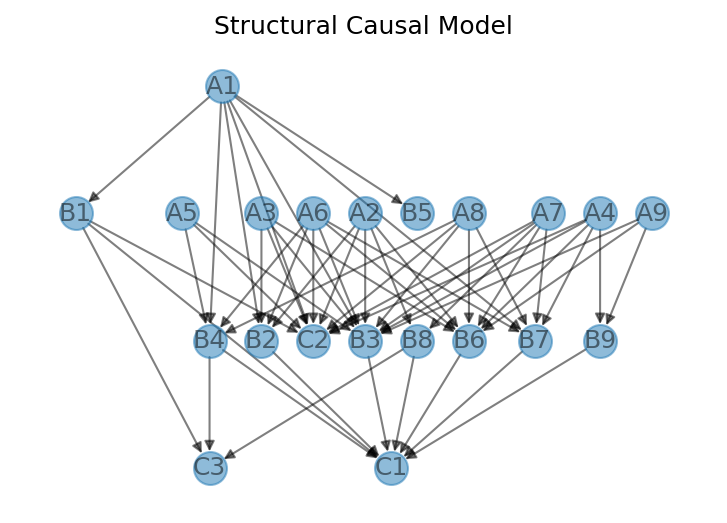

In [20]:
input_nodes = 30
if __name__ == "__main__":  
    if type(input_nodes) != list:
        scm = create_scm_from_num_nodes(input_nodes)
    else:
        scm = create_scm_from_nodes_list(input_nodes)
    scm.plot(node_size=250);

In [21]:
scm.sample(100)

C:\Users\uvgupta\software\miniconda3\envs\cdt\lib\site-packages\scmodels\scm.py:286: SymPyDeprecationWarning: 

The numsamples parameter to sympy.stats.sample() is deprecated.
Either use a list comprehension, like

[sample(...) for i in range(100)]

or add a dimension to size, like

sample(..., size=(100,))

See https://docs.sympy.org/latest/explanation/active-deprecations.html#deprecated-sympy-stats-numsamples
for details.

This has been deprecated since SymPy version 1.9. It
will be removed in a future version of SymPy.

  list(sample(noise_gen, numsamples=n, seed=seed)), dtype=float


,A1,A2,A3,A4,A5,A6,A7,A8,A9,B1,...,B2,B8,B4,B7,B3,B6,B9,C2,C3,C1
0,10.0,2.893370e-05,38.0,5.0,1.0,1.0,5.0,12.224424,1.0,80.0,...,0.000000,1.374871e-05,42251.236011,685.099084,404.725282,1.155936e+06,5.0,1.843136e+06,1.014030e+07,1.198877e+06
1,16.0,5.552197e-11,6.0,3.0,1.0,1.0,2.0,25.736841,3.0,32.0,...,9216.000000,1.076675e-11,137729.608630,95.210522,239.738284,5.722359e+06,0.0,9.956687e+03,4.407347e+06,8.069611e+06
2,10.0,4.573531e-17,15.0,6.0,1.0,1.0,5.0,103.082285,3.0,80.0,...,0.000000,2.233440e-17,847611.670398,633.493711,4344.855277,3.031075e+05,18.0,3.114999e+04,2.034268e+08,1.151371e+06
3,43.0,2.239221e-03,6.0,6.0,1.0,1.0,5.0,44.509438,3.0,344.0,...,66565.155443,2.762305e-03,608907.406342,315.056630,733.733699,6.729288e+06,0.0,1.359321e+05,2.094641e+08,7.338511e+06
4,16.0,8.885152e-07,38.0,3.0,1.0,1.0,4.0,10.239632,2.0,128.0,...,369664.001080,8.001133e-07,57418.330837,456.470065,124.945570,4.900990e+07,6.0,1.646361e+07,7.349546e+06,4.906778e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.0,1.509044e-02,6.0,3.0,1.0,1.0,5.0,16.725512,1.0,0.0,...,0.000000,1.243516e-02,22441.267939,496.588833,234.456320,3.363257e+06,0.0,0.000000e+00,1.243516e-02,3.386195e+06
96,0.0,3.991261e-10,1.0,3.0,1.0,0.0,1.0,15.333461,2.0,0.0,...,0.000000,1.010266e-10,20275.429201,414.003459,86.960261,6.150019e+02,0.0,0.000000e+00,1.010266e-10,2.130443e+04
97,10.0,5.006734e-05,1.0,4.0,1.0,1.0,1.0,5.093747,3.0,20.0,...,0.000000,6.693021e-06,19869.339602,125.499945,89.827663,2.116895e+03,12.0,1.091308e+04,7.947736e+05,2.212373e+04
98,10.0,9.070016e-04,15.0,7.0,1.0,1.0,4.0,10.360585,1.0,150.0,...,0.000000,2.050855e-04,33999.713269,86.524098,141.636860,2.340420e+07,7.0,4.144475e+04,1.019991e+07,2.343829e+07
